# OrionKL test with method 1

In [1]:
%matplotlib inline

import pickle
import os
import sys
import copy
import numpy as np

# filtering Astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

sys.path.append('../lib/')
from hdmclouds_v1 import *
from utils import *
from graph import *
from preprocessing import *
from gmr import *

from ipywidgets import interact, interactive, fixed, FloatSlider, IntSlider
from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt; plt.show()
matplotlib.rcParams.update({'font.size': 20})

#from pycupid import *

save_path = "/Users/martin/Dropbox/Aplicaciones/ShareLaTeX/HDMC-3rd_mnras_submission/figures/"

***
# 1) `../data/images/Orion.cont.image.fits`

/Users/martin/anaconda3/lib/python3.6/site-packages/spectral_cube/cube_utils.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  stokes_arrays[stokes_names[i_stokes]] = array[array_slice]


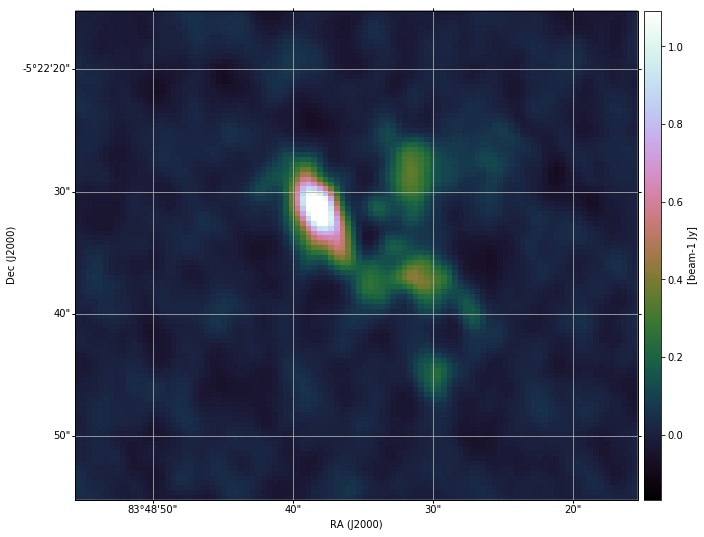

In [2]:
fits_path = '../data/images/Orion.cont.image.fits'
#fits_path = '../data/images/OphA_ExtnCambR_F.fits'
#fits_path = '../data/images/PerA_Extn2MASS_F_Gal.fits'
#fits_path = '../data/images/RhoOphiuchus60.fits'
#fits_path = '../data/images/perseus60.fits'
#fits_path = '../data/SCIMES/orion_12CO_mom0.fits'

loaded_fits = load_data(fits_path)
data = loaded_fits["data"]
hdu = loaded_fits["hdu"]
wcs = loaded_fits["wcs"]

base_level = estimate_rms(data)
image_plot(data, wcs=wcs, unit=hdu.header["BUNIT"])

In [3]:
preprocessing(data, wcs)

interactive(children=(FloatSlider(value=0.10237737624469602, description='back_level', max=0.20475475248939204…

[INFO] Number of pixels with significant emission: 749
[INFO] Level of compression: 26.702269692923895%
[INFO] Number of ICEs: 1
Isolated Cloud Entity A: 749 pixels of significant emission.


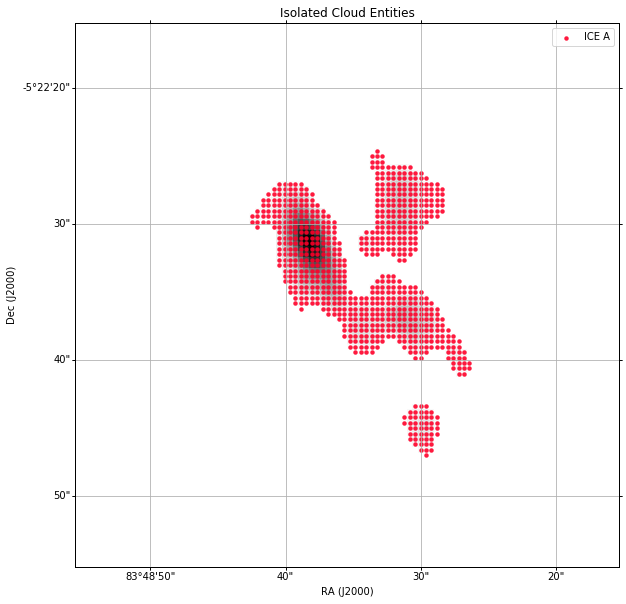

####################################################################################################


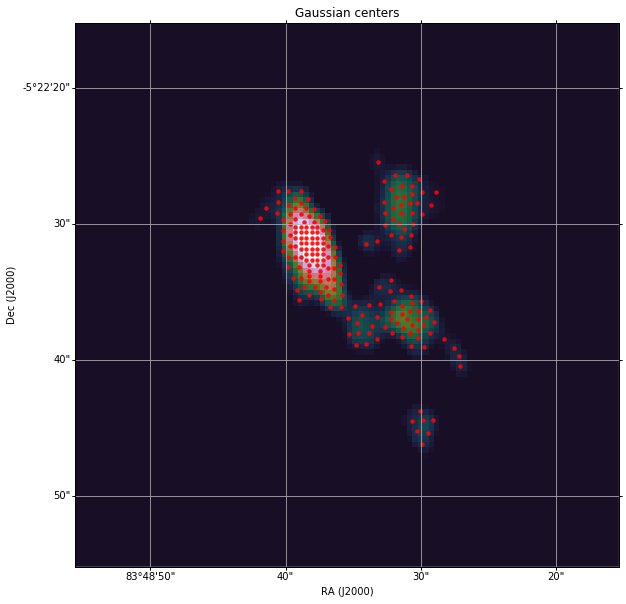

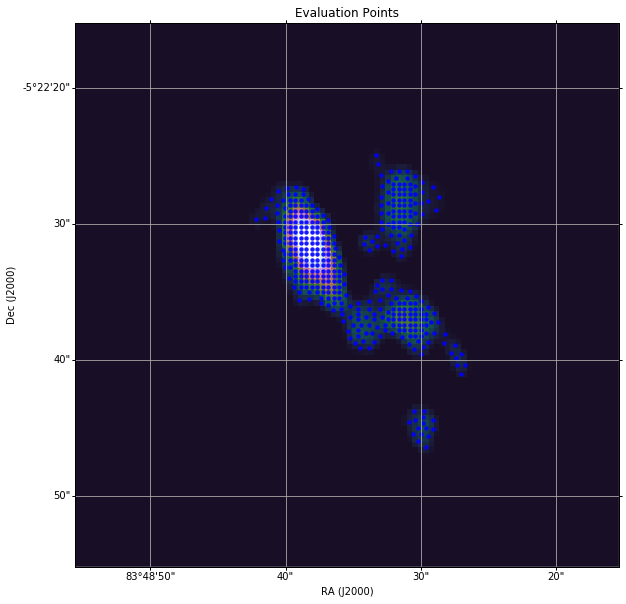

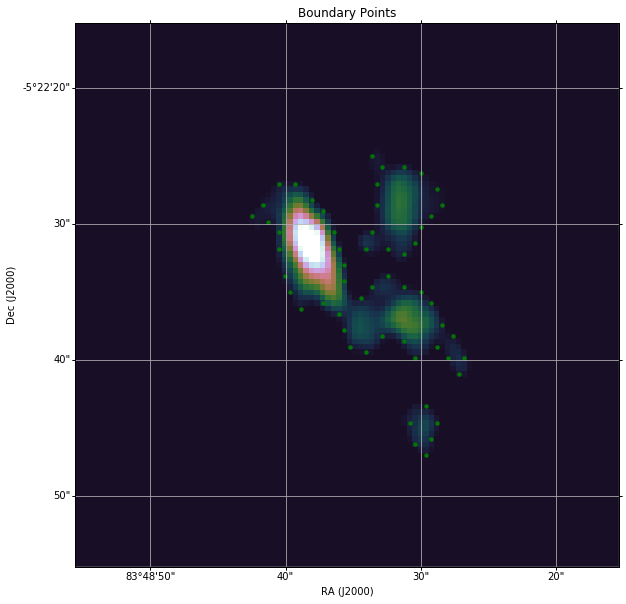

In [4]:
#%%prun -s tottime -q -l 30 -T gmr_v1.prof
hdmc = HDMClouds(data, back_level=0.089, wcs=wcs, verbose=True, n_gaussians=200, eps=100, kappa=2, gmr_neighbors=64)

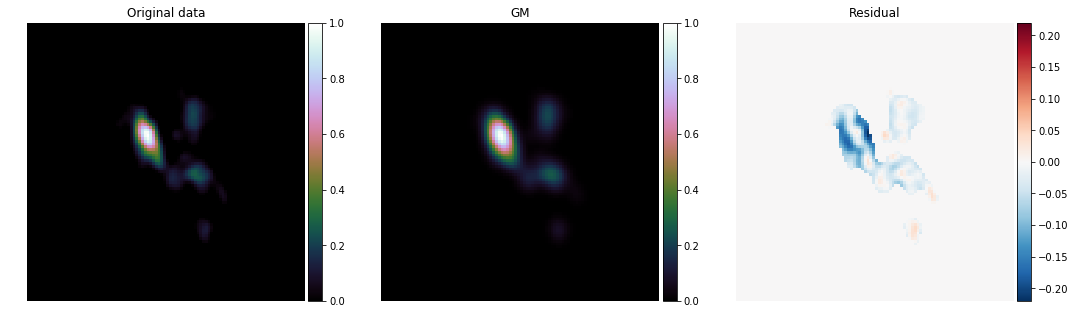

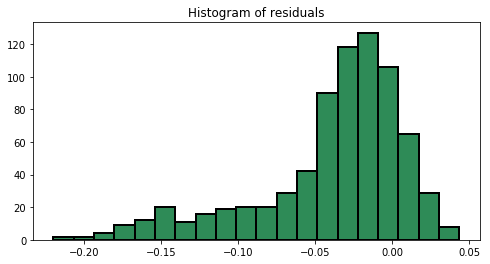

RESIDUAL STATS
RMS of residual: 0.061693325888863774
Inf norm of residual: 0.21966899963886904
Variance of residual: 0.002307213842370735
Normalized flux addition: 0.2732024706761136
Normalized flux lost: 0.01400816829207842


In [5]:
hdmc.get_residual_stats();

In [6]:
hdmc.build_gmr()

---------------------------------------------
Building GM for Isolated Cloud Entity A
---------------------------------------------
RESIDUAL STATS
RMS of residual: 0.005127170182669685
Inf norm of residual: 0.025525360798321226
Variance of residual: 2.5554097227224145e-05
Normalized flux addition: 0.01425041877236282
Normalized flux lost: 0.008515490396190832




In [7]:
#%%prun -s tottime -q -l 30 -T hdmc_m1.prof
times = []
rms_errors = []
inf_errors = []
for max_nfev in range(50, 3001, 50):
    print("MAX_NFEV:",max_nfev)
    tic = time.time()
    hdmc = HDMClouds(data, back_level=0.089, wcs=wcs, verbose=False, n_gaussians=200, eps=100, kappa=2, gmr_neighbors=64)
    hdmc.build_gmr(max_nfev=max_nfev)
    tac = time.time()
    times.append(tac-tic)
    rms,inf,_,_,_ = hdmc.get_residual_stats(verbose=False)
    rms_errors.append(rms)
    inf_errors.append(inf)
    print("RMS",rms)
    print("INF",inf)

MAX_NFEV: 50
[INFO] Number of pixels with significant emission: 749
[INFO] Level of compression: 26.702269692923895%
[INFO] Number of ICEs: 1
Isolated Cloud Entity A: 749 pixels of significant emission.
---------------------------------------------
Building GM for Isolated Cloud Entity A
---------------------------------------------
RESIDUAL STATS
RMS of residual: 0.061693325888837205
Inf norm of residual: 0.21966899963886904
Variance of residual: 0.002307213842375197
Normalized flux addition: 0.2732024760297952
Normalized flux lost: 0.014008168566679342


RMS 0.061693325888863774
INF 0.21966899963886904
MAX_NFEV: 100
[INFO] Number of pixels with significant emission: 749
[INFO] Level of compression: 26.702269692923895%
[INFO] Number of ICEs: 1
Isolated Cloud Entity A: 749 pixels of significant emission.
---------------------------------------------
Building GM for Isolated Cloud Entity A
---------------------------------------------
RESIDUAL STATS
RMS of residual: 0.061693325888837205

In [133]:
orionKLresults = {"times":times, "rms":rms_errors, "inf":inf_errors}
with open('exp-LM-orionKL.pickle', 'wb') as handle:
    pickle.dump(orionKLresults, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

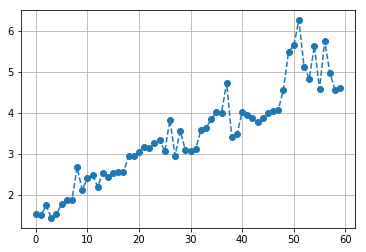

In [108]:
plt.plot(times, "o--")
plt.grid()
plt.show()

***

In [117]:
def makeup(errors_list):
    _errors = np.asarray(errors_list)
    unique_elements,counts_elements = np.unique(_errors, return_counts=True)
    unique_elements = unique_elements[::-1]
    
    np.random.seed(23)
    _errors = list()
    for i in range(len(unique_elements)-1):
        y2 = unique_elements[i]
        y1 = unique_elements[i+1]
        delta = (y2-y1)/counts_elements[i]
        _errors.append(y2)
        values = np.sort( (y2-y1)*np.random.random(counts_elements[i]-1)+y1 )[::-1]
        _errors += values.tolist()
    _errors += [unique_elements[-1]]*counts_elements[-1]
    return _errors

In [118]:
_rms_errors = makeup(rms_errors)
_inf_errors = makeup(inf_errors)

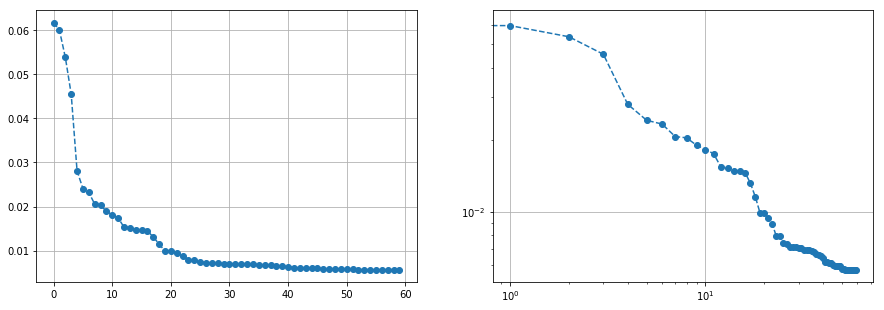

In [119]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(_rms_errors, "o--")
plt.grid()

plt.subplot(1,2,2)
plt.loglog(_rms_errors, "o--")
plt.grid()
plt.show()

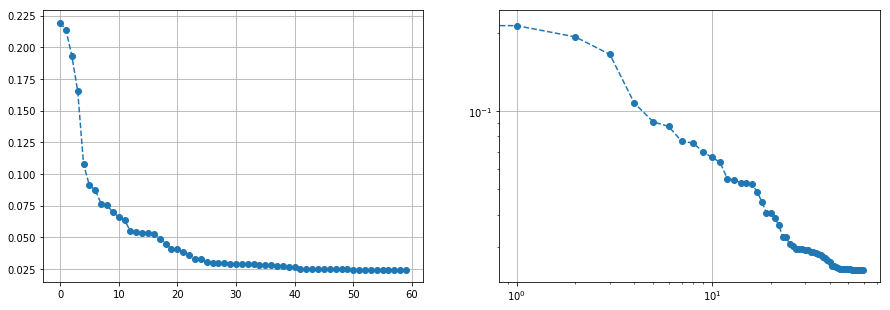

In [120]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(_inf_errors, "o--")
plt.grid()

plt.subplot(1,2,2)
plt.loglog(_inf_errors, "o--")
plt.grid()
plt.show()

***
# 2) `../data/SCIMES/orion_12CO_mom0.fits`

FITS not compatible with SpectralCube, loaded with AstroPy.


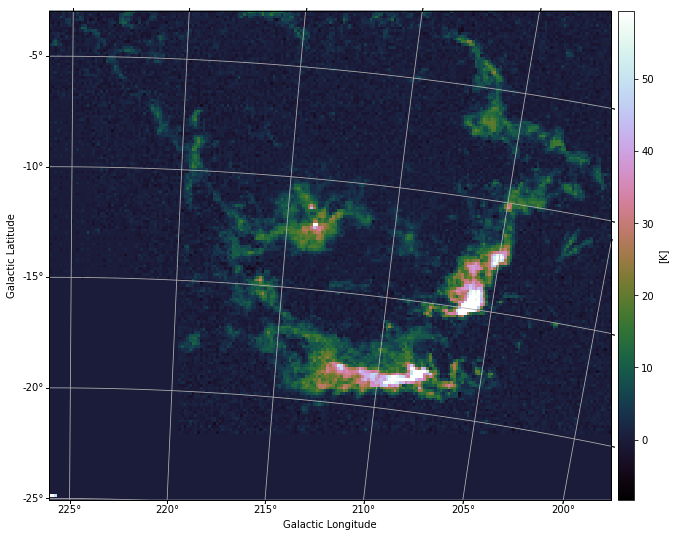

In [121]:
fits_path = '../data/SCIMES/orion_12CO_mom0.fits'

loaded_fits = load_data(fits_path)
data = loaded_fits["data"]
hdu = loaded_fits["hdu"]
wcs = loaded_fits["wcs"]

base_level = estimate_rms(data)
image_plot(data, wcs=wcs, unit=hdu.header["BUNIT"])

***
# 3) `../data/SCIMES/orion_12CO_mom0.fits`

/Users/martin/anaconda3/lib/python3.6/site-packages/spectral_cube/cube_utils.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  stokes_arrays[stokes_names[i_stokes]] = array[array_slice]


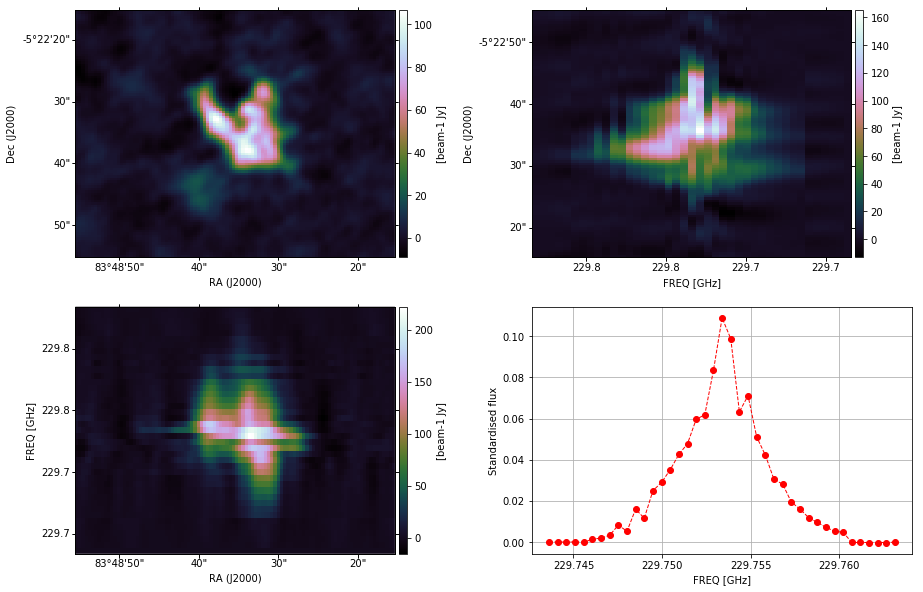

In [2]:
fits_path = '../data/cubes/Orion.methanol.cbc.contsub.image.fits'

loaded_fits = load_data(fits_path)
data = loaded_fits["data"]
hdu = loaded_fits["hdu"]
wcs = loaded_fits["wcs"]
spec = loaded_fits["spec"]

base_level = estimate_rms(data)
cube_plot(data, wcs=wcs, unit=hdu.header["BUNIT"], freq=spec)

In [3]:
#%%prun -s tottime -q -l 30 -T gmr_v1.prof
back_level = estimate_rms(data)
hdmc = HDMClouds(data, back_level=back_level, freq=spec, wcs=wcs, verbose=True, n_gaussians=650, eps=100, kappa=1, gmr_neighbors=64)

[INFO] Number of pixels with significant emission: 17411
[INFO] Level of compression: 3.7332720693814254%
[INFO] Number of ICEs: 1
Isolated Cloud Entity A: 17411 pixels of significant emission.


In [4]:
hdmc_test = copy.deepcopy(hdmc)

--------------------------------------------------------------------------------------------------------------
ORIGINAL DATA


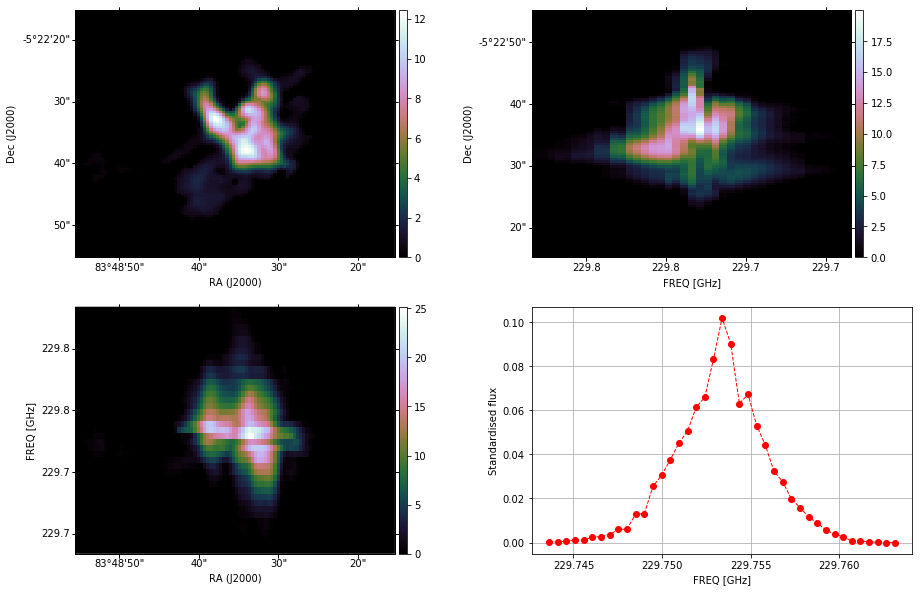

--------------------------------------------------------------------------------------------------------------
GAUSSIAN MIXTURE


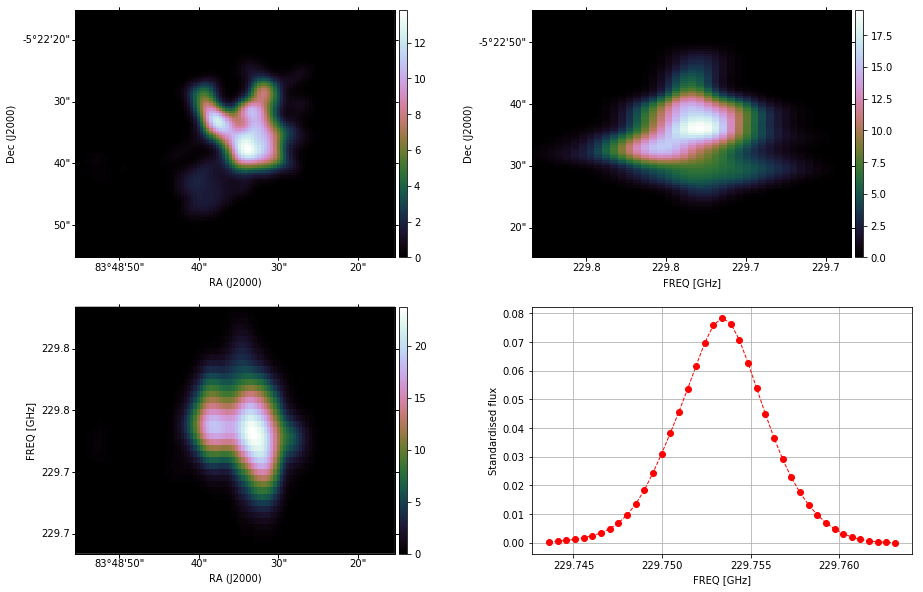

--------------------------------------------------------------------------------------------------------------
RESIDUAL


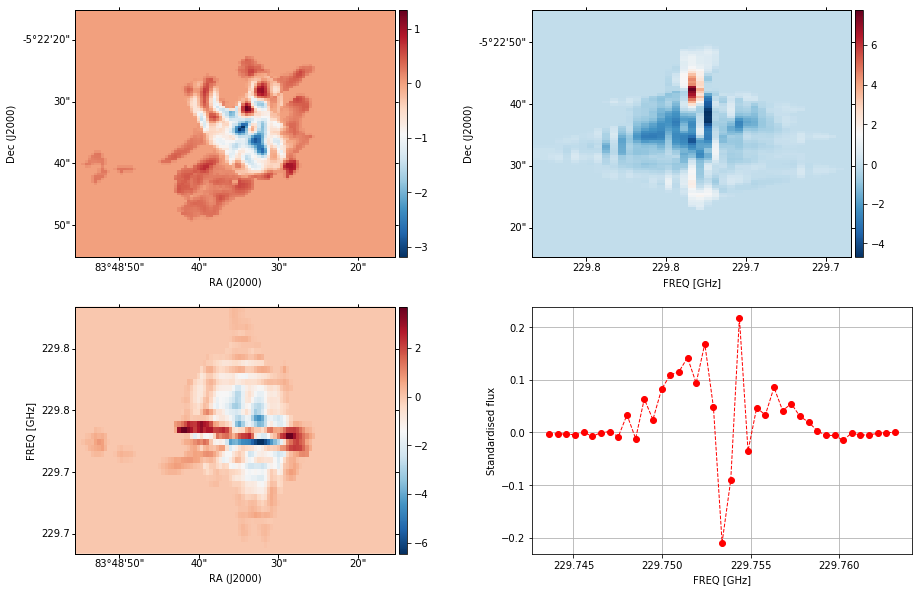

--------------------------------------------------------------------------------------------------------------
RESIDUAL STATS
RMS of residual: 0.019292264994189748
Inf norm of residual: 0.4242826619846239
Variance of residual: 0.00037167260125513506
Normalized flux addition: 0.13661144591293778
Normalized flux lost: 0.08402703029849894


In [5]:
hdmc.get_residual_stats();

In [6]:
hdmc_test.build_gmr(max_nfev=10000)

---------------------------------------------
Building GM for Isolated Cloud Entity A
---------------------------------------------
RESIDUAL STATS
RMS of residual: 0.05397538255135444
Inf norm of residual: 0.3429275960980815
Variance of residual: 0.002834663643854523
Normalized flux addition: 0.06964884028311655
Normalized flux lost: 0.042151682782834




In [ ]:
times = []
rms_errors = []
inf_errors = []
hdmc_ig = HDMClouds(data, back_level=back_level, freq=spec, wcs=wcs, verbose=True, n_gaussians=750, eps=100, kappa=1, gmr_neighbors=64)
for max_nfev in range(1000, 150000, 1000):
    print("MAX_NFEV:",max_nfev)
    hdmc = copy.deepcopy(hdmc_ig)
    hdmc.build_gmr(max_nfev=max_nfev)
    times.append(hdmc.elapsed_time)
    rms,inf,_,_,_ = hdmc.get_residual_stats(verbose=False)
    rms_errors.append(rms)
    inf_errors.append(inf)
    print("RMS",rms)
    print("INF",inf)
    del hdmc

[INFO] Number of pixels with significant emission: 17411
[INFO] Level of compression: 4.30762161851703%
[INFO] Number of ICEs: 1
Isolated Cloud Entity A: 17411 pixels of significant emission.
MAX_NFEV: 1000
---------------------------------------------
Building GM for Isolated Cloud Entity A
---------------------------------------------
RESIDUAL STATS
RMS of residual: 0.09409149518491502
Inf norm of residual: 0.4252808850326217
Variance of residual: 0.008503476650601525
Normalized flux addition: 0.1398741227494053
Normalized flux lost: 0.08190074949334442


RMS 0.01938980062343729
INF 0.4252808850326217
MAX_NFEV: 2000
---------------------------------------------
Building GM for Isolated Cloud Entity A
---------------------------------------------
RESIDUAL STATS
RMS of residual: 0.06073363323282276
Inf norm of residual: 0.3810095903159772
Variance of residual: 0.003262813824316283
Normalized flux addition: 0.09629318801720133
Normalized flux lost: 0.0323280999599404


RMS 0.01251575684

***